<a href="https://colab.research.google.com/github/BonellPatinoE/CD48-in-myeloma/blob/main/scRNAseq%20data%20analysis%20comparing%20NK%20cells%20in%20HD%20and%20MM%20patients_Zenodo_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
file_path = "/content/drive/My Drive/scRNAseq data/panImmune.h5ad"

In [ ]:
adata = sc.read_h5ad(file_path)

In [ ]:
print(adata)

AnnData object with n_obs × n_vars = 763657 × 34849
    obs: 'sample_id', 'study_id', 'donor_id', 'barcode', 'tissue', 'chem', 'sort', 'has_tcr', 'n_counts', 'log10_counts', 'n_genes', 'pct_counts_mt', 'pct_counts_hb', 'pct_counts_ig', 'scr_doublet', 'scr_doublet_score', 'UMAP1', 'UMAP2', 'MDE1', 'MDE2', 'leiden_0.6', 'lineage', 'pheno'
    var: 'gene', 'n_counts', 'n_cells_by_counts', 'mt', 'hb', 'ig'
    uns: 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_mde', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'


In [ ]:
adata.var_names[:5]  # Show first 5 gene names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1'], dtype='object')

In [ ]:
adata.obs_names[:5]  # Show first 5 cell IDs

Index(['Foster_2024.MGUS1_pos:1', 'Foster_2024.MGUS1_pos:2',
       'Foster_2024.MGUS1_pos:3', 'Foster_2024.MGUS1_pos:4',
       'Foster_2024.MGUS1_pos:5'],
      dtype='object', name='obs_names')

In [ ]:
print(adata.shape)  # (cells, genes)

(763657, 34849)


In [ ]:
# Check unique cell types in the 'lineage' column
print(adata.obs['lineage'].unique())

['T cell', 'Progenitor', 'Doublet', 'PC', 'Myeloid', 'NK cell', 'B cell', 'Nonhaem', 'Platelet', 'Neutrophil']
Categories (10, object): ['B cell', 'Doublet', 'Myeloid', 'NK cell', ..., 'PC', 'Platelet',
                          'Progenitor', 'T cell']


In [ ]:
# Check unique cell types in the 'sample_id' column
print(adata.obs['sample_id'].unique())

['Foster_2024.MGUS1_pos', 'Foster_2024.SMM9_neg', 'Foster_2024.SMM7_pos', 'Foster_2024.SMM3_neg', 'Foster_2024.SMM7_neg', ..., 'Stephenson_2021.CV0934', 'Stephenson_2021.CV0940', 'Stephenson_2021.CV0944', 'Foster_2024.MM2', 'Foster_2024.MM1']
Length: 214
Categories (214, object): ['Bailur_2019.hd1', 'Bailur_2019.hd2', 'Bailur_2019.hd3', 'Bailur_2019.hd4',
                           ..., 'Zheng_2021.P20190122-P', 'Zheng_2021.P20190122-T',
                           'Zheng_2021.P20190322-P', 'Zheng_2021.P20190322-T']


In [ ]:
# Check unique cell types in the 'tissue' column
print(adata.obs['tissue'].unique())

['BM', 'PB']
Categories (2, object): ['BM', 'PB']


In [ ]:
import re

# Define the patterns for each category
mm_patterns = r'Foster_2024.MM4_neg|Foster_2024.MM4_pos|Foster_2024.MM5_pos|Foster_2024.MM6_pos|Foster_2024.MM6_neg|' \
              r'Foster_2024.MM5_neg|Foster_2024.MM3_pos|Foster_2024.MM3_neg|Foster_2024.MM7_neg|Foster_2024.MM7_pos|' \
              r'Bailur_2019.mm2|Bailur_2019.mm5|Bailur_2019.mm4|Bailur_2019.mm3|Bailur_2019.mm11|Bailur_2019.mm10|' \
              r'Bailur_2019.mm8|Bailur_2019.mm6|Bailur_2019.mm1|Bailur_2019.mm7|Bailur_2019.mm9|' \
              r'Zavidij_2020.MM-5|Zavidij_2020.MM-1|Zavidij_2020.MM-8|Zavidij_2020.MM-6|Zavidij_2020.MM-3|' \
              r'Zavidij_2020.MM-7|Zavidij_2020.MM-4|Zheng_2021.P20181219-T|Zheng_2021.P20190122-P|' \
              r'Zheng_2021.P20190122-T|Zheng_2021.P20190322-P|Zheng_2021.P20190322-T|' \
              r'Liu_2021.77570_Primary|Liu_2021.59114_Primary|Liu_2021.83942_Primary|Liu_2021.58408_Primary|' \
              r'Liu_2021.47491_Primary|Liu_2021.57075_Primary|Liu_2021.37692_Primary|Liu_2021.60359_Primary|' \
              r'Liu_2021.56203_Primary|Maura_2023.PT11|Maura_2023.PT12|Maura_2023.PT18|Maura_2023.PT13|' \
              r'Maura_2023.PT15|Maura_2023.PT55|Maura_2023.PT78|Maura_2023.PT85|Maura_2023.PT03|' \
              r'Maura_2023.PT30|Maura_2023.PT32|Maura_2023.PT33|Maura_2023.PT39|Maura_2023.PT49|' \
              r'Maura_2023.PT58|Maura_2023.PT59|Maura_2023.PT63|Foster_2024.MM2|Foster_2024.MM1'
smm_patterns = r'Foster_2024.SMM9_neg|Foster_2024.SMM7_pos|Foster_2024.SMM3_neg|Foster_2024.SMM7_neg|' \
              r'Foster_2024.SMM9_pos|Foster_2024.SMM12_pos|Foster_2024.SMM6_neg|Foster_2024.SMM8_pos|' \
              r'Foster_2024.SMM8_neg|Foster_2024.SMM6_pos|Foster_2024.SMM12_neg|Foster_2024.SMM4_pos|' \
              r'Foster_2024.SMM5_pos|Foster_2024.SMM5_neg|Foster_2024.SMM4_neg|Foster_2024.SMM11_neg|' \
              r'Foster_2024.SMM10_pos|Foster_2024.SMM2_neg|Foster_2024.SMM1_pos|Foster_2024.SMM1_neg|' \
              r'Foster_2024.SMM2_pos|Foster_2024.SMM10_neg|Foster_2024.SMM11_pos|Foster_2024.SMM14_neg|' \
              r'Foster_2024.SMM14_pos|Foster_2024.SMM13_neg|Foster_2024.SMM13_pos|' \
              r'Zavidij_2020.SMMh-4|Zavidij_2020.SMMl-1|Zavidij_2020.SMMh-10|Zavidij_2020.SMMh-3|' \
              r'Zavidij_2020.SMMh-7|Zavidij_2020.SMMh-2|Zavidij_2020.SMMh-9|Zavidij_2020.SMMh-6|' \
              r'Zavidij_2020.SMMl-3|Zavidij_2020.SMMh-8|Zavidij_2020.SMMl-2|' \
              r'Liu_2021.47491_SMM|Liu_2021.58408_SMM|Liu_2021.37692_SMM'
mgus_patterns = r'Foster_2024.MGUS1_pos|Foster_2024.MGUS1_neg|' \
                r'Bailur_2019.mgus14|Bailur_2019.mgus13|Bailur_2019.mgus4|Bailur_2019.mgus3|' \
                r'Bailur_2019.mgus2|Bailur_2019.mgus5|Bailur_2019.mgus12|Bailur_2019.mgus10|' \
                r'Bailur_2019.mgus9|Bailur_2019.mgus7|Bailur_2019.mgus6|Bailur_2019.mgus1|' \
                r'Bailur_2019.mgus8|Bailur_2019.mgus11|' \
                r'Zavidij_2020.MGUS-1|Zavidij_2020.MGUS-4|Zavidij_2020.MGUS-3|' \
                r'Zavidij_2020.MGUS-2|Zavidij_2020.MGUS-6'
hd_patterns = r'Foster_2024.HD3_neg|Foster_2024.HD2_pos|Foster_2024.HD2_neg|' \
              r'Foster_2024.HD3_pos|Foster_2024.HD1_pos|Foster_2024.HD1_neg|' \
              r'Oetjen_2018.G|Oetjen_2018.S_T1|Oetjen_2018.U|Oetjen_2018.T|' \
              r'Oetjen_2018.W|Oetjen_2018.L|Oetjen_2018.B|Oetjen_2018.C_T1_S1|' \
              r'Oetjen_2018.O|Oetjen_2018.P|Oetjen_2018.M|Oetjen_2018.N|' \
              r'Oetjen_2018.Q|Oetjen_2018.J|Oetjen_2018.C_T1_S2|Oetjen_2018.A|' \
              r'Oetjen_2018.F|Oetjen_2018.C_T2|Oetjen_2018.S_T2|Oetjen_2018.K|' \
              r'Oetjen_2018.E|Oetjen_2018.H|Oetjen_2018.R|' \
              r'Bailur_2019.hd1|Bailur_2019.hd6|Bailur_2019.hd8|Bailur_2019.hd7|' \
              r'Bailur_2019.hd5|Bailur_2019.hd2|Bailur_2019.hd3|Bailur_2019.hd4|' \
              r'Zavidij_2020.NBM-10|Zavidij_2020.NBM-5|Zavidij_2020.NBM-9|' \
              r'Zavidij_2020.NBM-11|Zavidij_2020.NBM-2|Zavidij_2020.NBM-1|' \
              r'Zavidij_2020.NBM-8|Kfoury_2021.BMM4|Kfoury_2021.BMM8|Kfoury_2021.BMM3|' \
              r'Kfoury_2021.BMM9|Kfoury_2021.BMM5|Kfoury_2021.BMM6|Kfoury_2021.BMM2|' \
              r'Granja_2019.BMMC_D1T1|Granja_2019.BMMC_D1T2|Conde_2022.A29_BMA|' \
              r'Conde_2022.A31_BMA|Conde_2022.A36_BMA|Conde_2022.A36_BLD|' \
              r'Conde_2022.A35_BMA|Conde_2022.A35_BLD|Conde_2022.A37_BMA|' \
              r'Conde_2022.621B_BMA|Conde_2022.637C_BMA|Conde_2022.637C_BLD|' \
              r'Conde_2022.640C_BMA|Conde_2022.D503_BMA|Conde_2022.D503_BLD|' \
              r'Conde_2022.D496_BMA|Conde_2022.D496_BLD|Stephenson_2021.newcastle65|' \
              r'Stephenson_2021.MH8919226|Stephenson_2021.MH8919333|Stephenson_2021.MH8919332|' \
              r'Stephenson_2021.MH8919227|Stephenson_2021.MH8919283|Stephenson_2021.MH8919178|' \
              r'Stephenson_2021.MH8919177|Stephenson_2021.MH8919176|Stephenson_2021.MH8919179|' \
              r'Stephenson_2021.newcastle74|Stephenson_2021.MH8919282|Stephenson_2021.CV0904|' \
              r'Stephenson_2021.CV0902|Stephenson_2021.CV0911|Stephenson_2021.CV0929|' \
              r'Stephenson_2021.CV0915|Stephenson_2021.CV0917|Stephenson_2021.CV0939|' \
              r'Stephenson_2021.CV0926|Stephenson_2021.CV0934|Stephenson_2021.CV0940|' \
              r'Stephenson_2021.CV0944'

# Function to categorize sample_id
def categorize_sample(sample):
    if re.search(mm_patterns, sample, re.IGNORECASE):
        return "MM"
    elif re.search(smm_patterns, sample, re.IGNORECASE):
        return "SMM"
    elif re.search(mgus_patterns, sample, re.IGNORECASE):
        return "MGUS"
    elif re.search(hd_patterns, sample, re.IGNORECASE):
        return "HD"
    else:
        return "Unknown"  # Default to Unknown if no match is found

# Extract sample_ids from adata.obs
sample_ids = adata.obs['sample_id'].unique()

# Create the DataFrame
df = pd.DataFrame(sample_ids, columns=["sample_id"])

# Apply the function to categorize the sample_id
df["sample_category"] = df["sample_id"].apply(categorize_sample)

# Display the DataFrame
print(df[['sample_id', 'sample_category']])

                  sample_id sample_category
0     Foster_2024.MGUS1_pos            MGUS
1      Foster_2024.SMM9_neg             SMM
2      Foster_2024.SMM7_pos             SMM
3      Foster_2024.SMM3_neg             SMM
4      Foster_2024.SMM7_neg             SMM
..                      ...             ...
209  Stephenson_2021.CV0934              HD
210  Stephenson_2021.CV0940              HD
211  Stephenson_2021.CV0944              HD
212         Foster_2024.MM2              MM
213         Foster_2024.MM1              MM

[214 rows x 2 columns]


In [ ]:
# Apply the function to categorize the sample_id and update adata.obs
adata.obs['sample_category'] = adata.obs['sample_id'].apply(categorize_sample)

# Check the result
print(adata.obs[['sample_id', 'sample_category']])

                                     sample_id sample_category
obs_names                                                     
Foster_2024.MGUS1_pos:1  Foster_2024.MGUS1_pos            MGUS
Foster_2024.MGUS1_pos:2  Foster_2024.MGUS1_pos            MGUS
Foster_2024.MGUS1_pos:3  Foster_2024.MGUS1_pos            MGUS
Foster_2024.MGUS1_pos:4  Foster_2024.MGUS1_pos            MGUS
Foster_2024.MGUS1_pos:5  Foster_2024.MGUS1_pos            MGUS
...                                        ...             ...
Foster_2024.MM1:9015           Foster_2024.MM1              MM
Foster_2024.MM1:9016           Foster_2024.MM1              MM
Foster_2024.MM1:9017           Foster_2024.MM1              MM
Foster_2024.MM1:9018           Foster_2024.MM1              MM
Foster_2024.MM1:9019           Foster_2024.MM1              MM

[763657 rows x 2 columns]


In [ ]:
import pandas as pd

# Example: Create a DataFrame for sample_id and sample_category comparison
sample_ids = adata.obs['sample_id'].unique()
df = pd.DataFrame(sample_ids, columns=["sample_id"])

# Apply the categorization function to the sample_id column
df["sample_category"] = df["sample_id"].apply(categorize_sample)

# Save the DataFrame to a CSV file
df.to_csv('/content/sample_comparison.csv', index=False)

# Provide a download link
from google.colab import files
files.download('/content/sample_comparison.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Replace sample_id with sample_category
adata.obs['sample_id'] = adata.obs['sample_category']

# Drop the sample_category column if no longer needed
adata.obs.drop('sample_category', axis=1, inplace=True)

# Check the result
print(adata.obs[['sample_id']])

                        sample_id
obs_names                        
Foster_2024.MGUS1_pos:1      MGUS
Foster_2024.MGUS1_pos:2      MGUS
Foster_2024.MGUS1_pos:3      MGUS
Foster_2024.MGUS1_pos:4      MGUS
Foster_2024.MGUS1_pos:5      MGUS
...                           ...
Foster_2024.MM1:9015           MM
Foster_2024.MM1:9016           MM
Foster_2024.MM1:9017           MM
Foster_2024.MM1:9018           MM
Foster_2024.MM1:9019           MM

[763657 rows x 1 columns]


In [ ]:
# Filter adata for NK cells and BM tissue
nk_bm_adata = adata[(adata.obs['lineage'] == 'NK cell') & (adata.obs['tissue'] == 'BM')].copy()

In [ ]:
# Check filtered data
print(nk_bm_adata)
print(nk_bm_adata.obs['sample_id'].value_counts())  # Verify category counts

AnnData object with n_obs × n_vars = 37957 × 34849
    obs: 'sample_id', 'study_id', 'donor_id', 'barcode', 'tissue', 'chem', 'sort', 'has_tcr', 'n_counts', 'log10_counts', 'n_genes', 'pct_counts_mt', 'pct_counts_hb', 'pct_counts_ig', 'scr_doublet', 'scr_doublet_score', 'UMAP1', 'UMAP2', 'MDE1', 'MDE2', 'leiden_0.6', 'lineage', 'pheno'
    var: 'gene', 'n_counts', 'n_cells_by_counts', 'mt', 'hb', 'ig'
    uns: 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_mde', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'
sample_id
MM      13854
HD      13251
SMM      7996
MGUS     2856
Name: count, dtype: int64


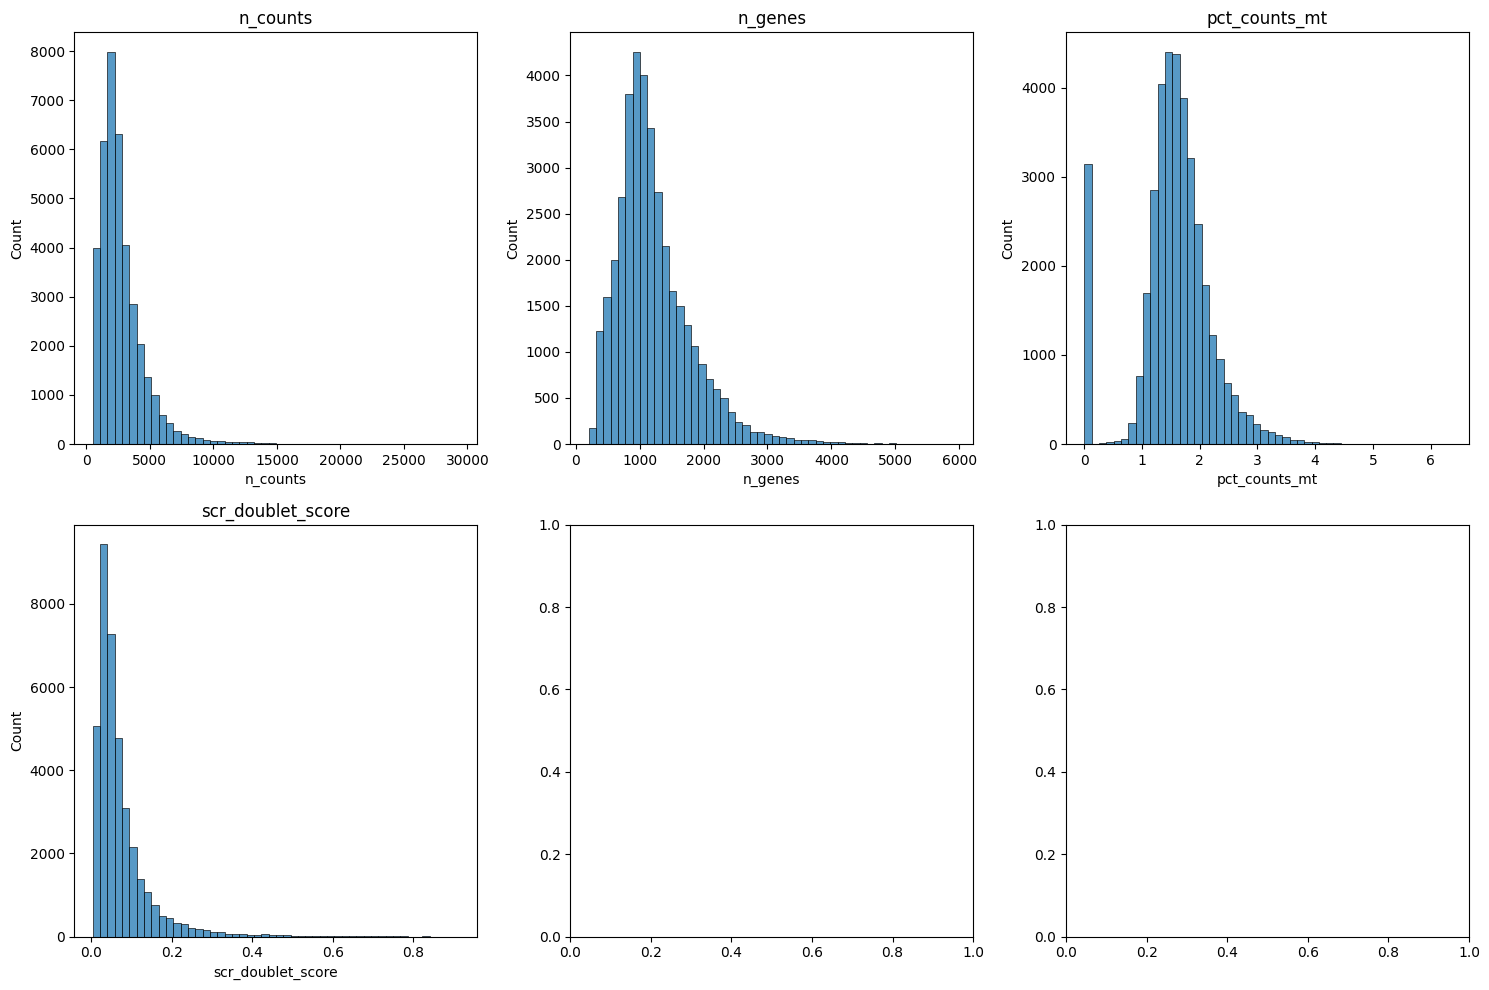

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms for key parameters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.histplot(nk_bm_adata.obs['n_counts'], bins=50, ax=axes[0, 0]).set(title="n_counts")
sns.histplot(nk_bm_adata.obs['n_genes'], bins=50, ax=axes[0, 1]).set(title="n_genes")
sns.histplot(nk_bm_adata.obs['pct_counts_mt'], bins=50, ax=axes[0, 2]).set(title="pct_counts_mt")
sns.histplot(nk_bm_adata.obs['scr_doublet_score'], bins=50, ax=axes[1, 0]).set(title="scr_doublet_score")

plt.tight_layout()
plt.show()


In [ ]:
print(nk_bm_adata.obs['scr_doublet'].dtype)
print(nk_bm_adata.obs['scr_doublet'].unique())

category
['False', 'True']
Categories (2, object): ['False', 'True']


In [ ]:
print("Total cells before filtering:", nk_bm_adata.shape[0])

Total cells before filtering: 37957


In [ ]:
print("Passing n_genes > 500:", nk_bm_adata[nk_bm_adata.obs['n_genes'] > 500].shape[0])

Passing n_genes > 500: 35566


In [ ]:
print("Passing n_genes <= 50000:", nk_bm_adata[nk_bm_adata.obs['n_genes'] <= 5000].shape[0])

Passing n_genes <= 50000: 37944


In [ ]:
print("Passing n_counts >= 1000:", nk_bm_adata[nk_bm_adata.obs['n_counts'] >= 1000].shape[0])

Passing n_counts >= 1000: 34551


In [ ]:
print("Passing n_counts <= 10000:", nk_bm_adata[nk_bm_adata.obs['n_counts'] <= 10000].shape[0])

Passing n_counts <= 10000: 37599


In [ ]:
print("Passing pct_counts_mt < 10:", nk_bm_adata[nk_bm_adata.obs['pct_counts_mt'] < 10].shape[0])

Passing pct_counts_mt < 10: 37957


In [ ]:
print("Passing scr_doublet == True:", nk_bm_adata[nk_bm_adata.obs['scr_doublet'] == True].shape[0])

Passing scr_doublet == True: 0


In [ ]:
# Apply QC filters
filtered_adata = nk_bm_adata[
    (nk_bm_adata.obs['n_genes'] > 500) &
    (nk_bm_adata.obs['n_genes'] <= 5000) &
    (nk_bm_adata.obs['n_counts'] >= 1000) &
    (nk_bm_adata.obs['n_counts'] <= 10000) &
    (nk_bm_adata.obs['pct_counts_mt'] < 10)  # Mitochondrial percentage filter
].copy()

# Check filtered data
print(filtered_adata)
print(filtered_adata.obs['sample_id'].value_counts())

AnnData object with n_obs × n_vars = 34113 × 34849
    obs: 'sample_id', 'study_id', 'donor_id', 'barcode', 'tissue', 'chem', 'sort', 'has_tcr', 'n_counts', 'log10_counts', 'n_genes', 'pct_counts_mt', 'pct_counts_hb', 'pct_counts_ig', 'scr_doublet', 'scr_doublet_score', 'UMAP1', 'UMAP2', 'MDE1', 'MDE2', 'leiden_0.6', 'lineage', 'pheno'
    var: 'gene', 'n_counts', 'n_cells_by_counts', 'mt', 'hb', 'ig'
    uns: 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_mde', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'
sample_id
HD      12647
MM      11426
SMM      7412
MGUS     2628
Name: count, dtype: int64


In [ ]:
### NEW ANALYSIS IN NK CELLS

hd_mm_adata = filtered_adata[filtered_adata.obs['sample_id'].isin(['HD', 'MM'])].copy()

In [ ]:
#import scanpy as sc

# Step 1: Normalize total counts
#sc.pp.normalize_total(hd_mm_adata, target_sum=1e4)

# Step 2: Log transform the data
#sc.pp.log1p(hd_mm_adata)

# Step 3: (Optional) Z-score scaling
#sc.pp.scale(hd_mm_adata)


In [ ]:
import scanpy as sc

#sc.tl.rank_genes_groups(hd_mm_adata, groupby='sample_id', reference='HD', method='wilcoxon')
#"t-test"

In [ ]:
sc.tl.rank_genes_groups(hd_mm_adata, groupby='sample_id', reference='HD', method='wilcoxon', corr_method='bonferroni')

In [ ]:
import pandas as pd
import numpy as np

# Convert to DataFrame
de_results = pd.DataFrame({
    'gene': hd_mm_adata.var_names,
    'logFC': hd_mm_adata.uns['rank_genes_groups']['logfoldchanges']['MM'],
    'pval': hd_mm_adata.uns['rank_genes_groups']['pvals']['MM'],
    'pval_adj': hd_mm_adata.uns['rank_genes_groups']['pvals_adj']['MM']
})

# Compute -log10(p-value) for the volcano plot
de_results['-log10(pval)'] = -np.log10(de_results['pval'])


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


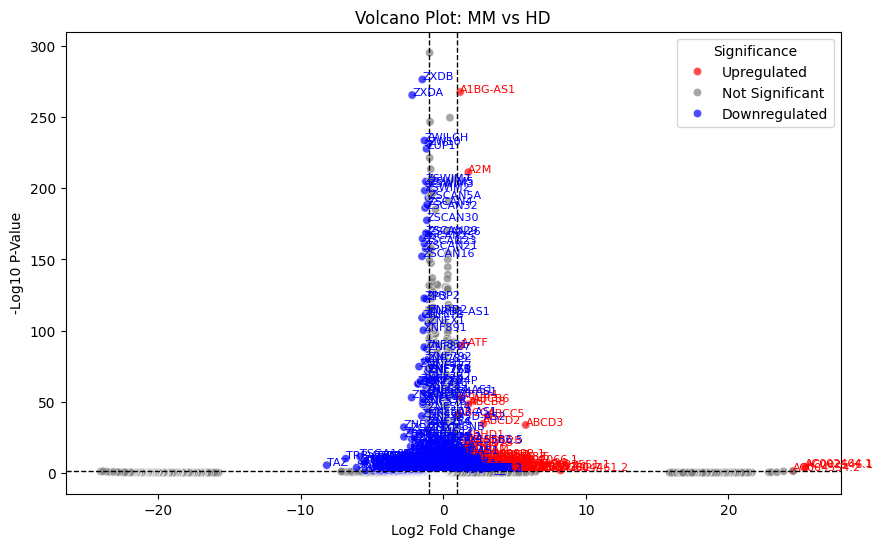

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Downregulated'

# Volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=de_results, x='logFC', y='-log10(pval)', hue='significance', # Changed y to '-log10(pval)'
                palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.7)

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Labels for upregulated and downregulated genes
upregulated_genes = de_results.loc[(de_results['significance'] == 'Upregulated')]
downregulated_genes = de_results.loc[(de_results['significance'] == 'Downregulated')]

# Label upregulated genes
for i, row in upregulated_genes.iterrows():
    plt.text(row['logFC'], row['-log10(pval)'], row['gene'], fontsize=8, color='red')  # Changed y to row['-log10(pval)']

# Label downregulated genes
for i, row in downregulated_genes.iterrows():
    plt.text(row['logFC'], row['-log10(pval)'], row['gene'], fontsize=8, color='blue')  # Changed y to row['-log10(pval)']


# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD")
plt.legend(title="Significance")
plt.show()

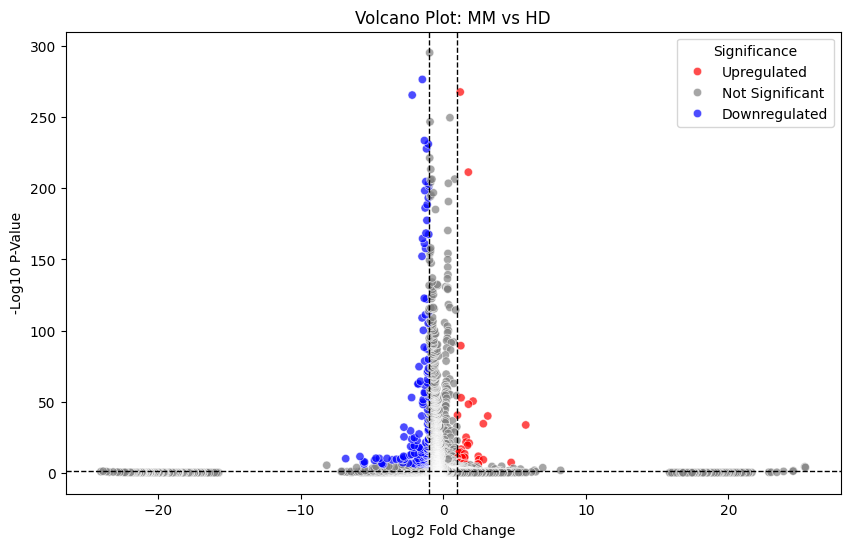

In [ ]:
#### NEW VOLCANO PLOT ####

## Red dots: Upregulated in MM (logFC > 1, adjusted p-value < 0.05).
#Blue dots: Downregulated in MM (logFC < -1, adjusted p-value < 0.05).
#Gray dots: Non-significant genes.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval_adj'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval_adj'] < pval_threshold), 'significance'] = 'Downregulated'

# Volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=de_results, x='logFC', y='-log10(pval)', hue='significance',
                palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.7)

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD")
plt.legend(title="Significance")
plt.show()


In [ ]:
import pandas as pd

# Create a new dataframe with relevant columns: Gene, logFC, -log10(p-value)
volcano_data = de_results[['gene', 'logFC', 'pval_adj']].copy()

# Calculate -log10(p-value)
volcano_data['-log10(pval)'] = -np.log10(volcano_data['pval_adj'])

# Save to CSV
volcano_data.to_csv('/content/volcano_plot_data.csv', index=False)

# To allow download in Google Colab
from google.colab import files
files.download('/content/volcano_plot_data.csv')


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

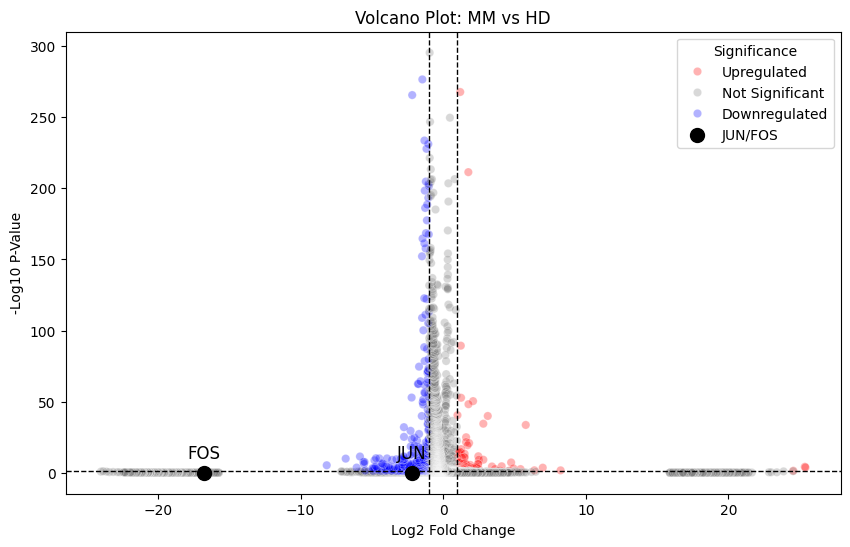

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Downregulated'

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all genes
sns.scatterplot(data=de_results, x='logFC', y='-log10(pval)', hue='significance',
                palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.3)

# Highlight specific genes (e.g., Jun and Fos)
highlight_genes = ['JUN', 'FOS']
highlight_data = de_results[de_results['gene'].isin(highlight_genes)]

# Plot these genes in black with larger markers
plt.scatter(highlight_data['logFC'], -np.log10(highlight_data['pval']), color='black', s=100, label='JUN/FOS')

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD")

# Add gene labels for Jun and Fos
for i, row in highlight_data.iterrows():
    plt.text(row['logFC'], -np.log10(row['pval']) + 10, row['gene'], fontsize=12, ha='center', color='black')

plt.legend(title="Significance")
plt.show()


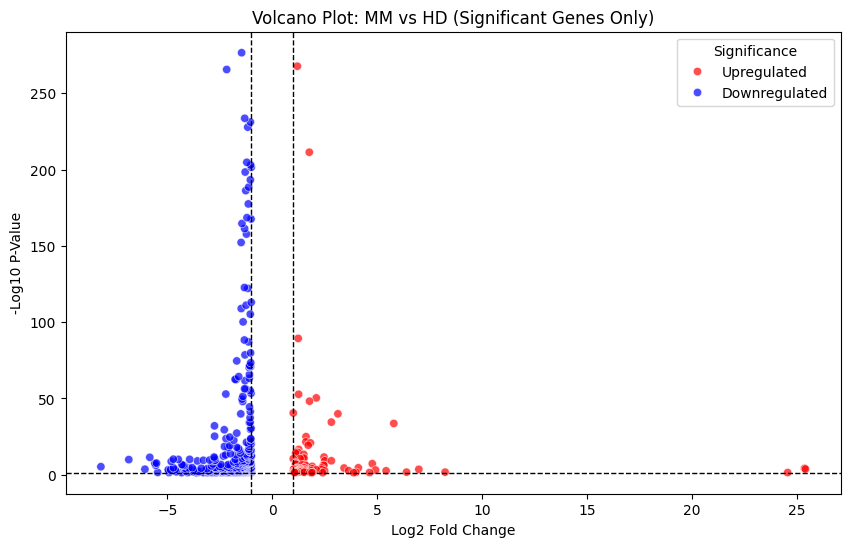

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Downregulated'

# Filter only significant genes
significant_genes = de_results[de_results['significance'] != 'Not Significant']

# Volcano plot for significant genes only
plt.figure(figsize=(10, 6))

# Plot only significant genes
sns.scatterplot(data=significant_genes, x='logFC', y='-log10(pval)', hue='significance',
                palette={'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.7)

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD (Significant Genes Only)")

# Display plot
plt.legend(title="Significance")
plt.show()


In [ ]:
# Create a DataFrame with the necessary columns
volcano_data = de_results[['gene', 'logFC', 'pval']]
volcano_data['-log10(pval)'] = -np.log10(volcano_data['pval'])

# Save the DataFrame as a CSV file
volcano_data.to_csv('volcano_plot_data.csv', index=False)

from google.colab import files

# Download the CSV file
files.download('volcano_plot_data.csv')


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-2069344866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcano_data['-log10(pval)'] = -np.log10(volcano_data['pval'])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2214113555.py:31: RuntimeWarning: divide by zero encountered in log10
  -np.log10(upregulated_genes.iloc[i]['pval_adj']),
/tmp/ipython-input-2214113555.py:38: RuntimeWarning: divide by zero encountered in log10
  -np.log10(downregulated_genes.iloc[i]['pval_adj']),


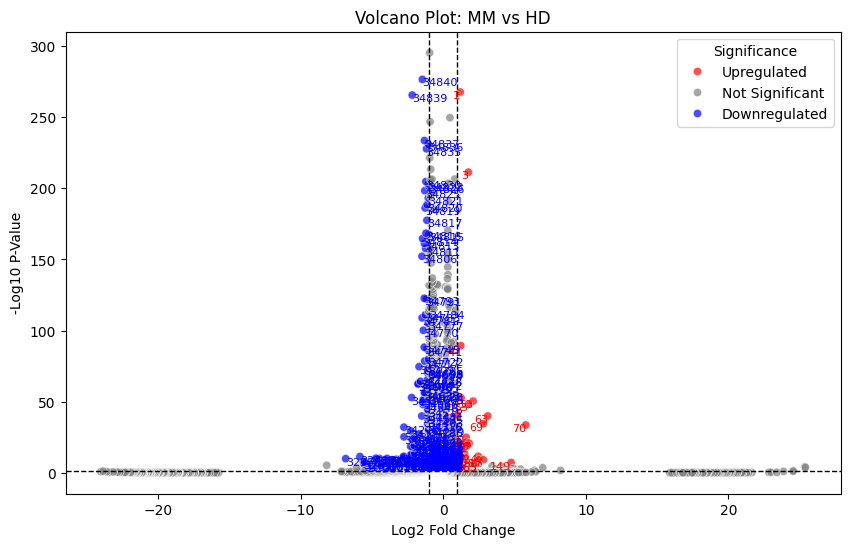

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval_adj'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval_adj'] < pval_threshold), 'significance'] = 'Downregulated'

# Volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=de_results, x='logFC', y='-log10(pval)', hue='significance',
                palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.7)

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Label the significant genes (upregulated and downregulated)
upregulated_genes = de_results.loc[(de_results['significance'] == 'Upregulated')]
downregulated_genes = de_results.loc[(de_results['significance'] == 'Downregulated')]

# Label upregulated genes
for i in range(upregulated_genes.shape[0]):
    plt.text(upregulated_genes.iloc[i]['logFC'],
             -np.log10(upregulated_genes.iloc[i]['pval_adj']),
             upregulated_genes.iloc[i].name,  # Using gene name as label
             fontsize=8, color='red', ha='right')

# Label downregulated genes
for i in range(downregulated_genes.shape[0]):
    plt.text(downregulated_genes.iloc[i]['logFC'],
             -np.log10(downregulated_genes.iloc[i]['pval_adj']),
             downregulated_genes.iloc[i].name,  # Using gene name as label
             fontsize=8, color='blue', ha='left')

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD")
plt.legend(title="Significance")
plt.show()


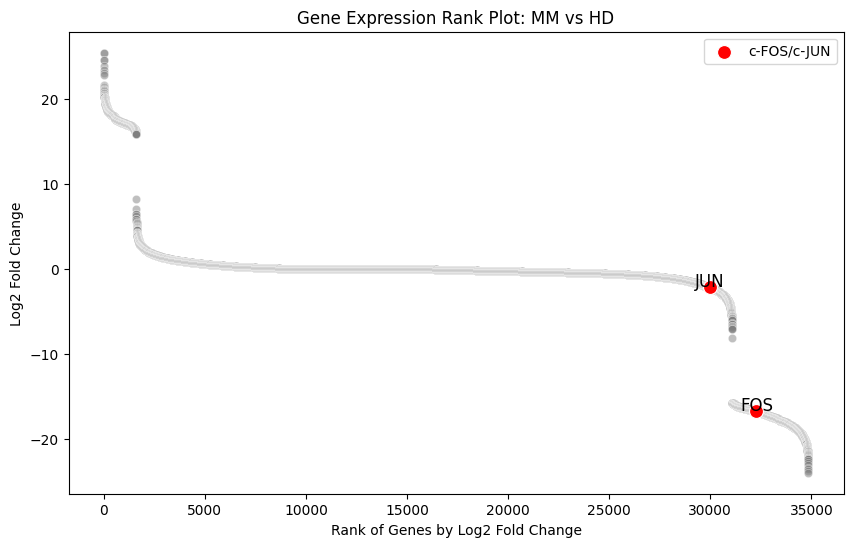

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort genes by logFC and reset index to get ranks
de_results_sorted = de_results.sort_values(by='logFC', ascending=False).reset_index(drop=True)
de_results_sorted['rank'] = de_results_sorted.index + 1  # Rank starts from 1

# Define genes to highlight
highlight_genes = ['JUN', 'FOS', 'c-JUN', 'c-FOS']  # Ensure gene names match your dataset
highlight_data = de_results_sorted[de_results_sorted['gene'].isin(highlight_genes)]

# Create plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=de_results_sorted, x='rank', y='logFC', color='gray', alpha=0.5)

# Highlight c-FOS and c-JUN
sns.scatterplot(data=highlight_data, x='rank', y='logFC', color='red', s=100, label='c-FOS/c-JUN')

# Add gene labels for c-FOS and c-JUN
for i, row in highlight_data.iterrows():
    plt.text(row['rank'], row['logFC'] + 0.1, row['gene'], fontsize=12, ha='center', color='black')

# Labels and title
plt.xlabel("Rank of Genes by Log2 Fold Change")
plt.ylabel("Log2 Fold Change")
plt.title("Gene Expression Rank Plot: MM vs HD")

plt.legend()
plt.show()


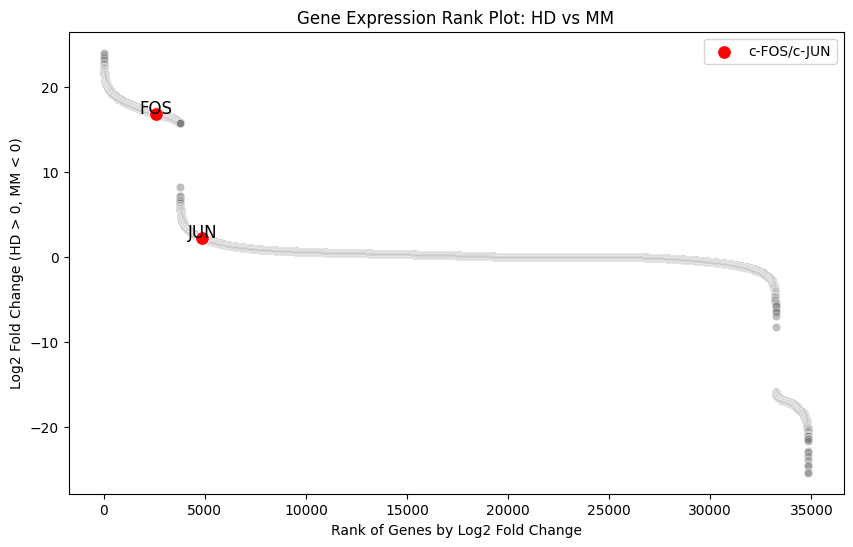

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flip log2 fold change so that HD is positive and MM is negative
de_results['logFC_flipped'] = -de_results['logFC']

# Sort genes by new logFC and reset index to get ranks
de_results_sorted = de_results.sort_values(by='logFC_flipped', ascending=False).reset_index(drop=True)
de_results_sorted['rank'] = de_results_sorted.index + 1  # Rank starts from 1

# Define genes to highlight
highlight_genes = ['JUN', 'FOS', 'c-JUN', 'c-FOS']  # Ensure gene names match your dataset
highlight_data = de_results_sorted[de_results_sorted['gene'].isin(highlight_genes)]

# Create plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=de_results_sorted, x='rank', y='logFC_flipped', color='gray', alpha=0.5)

# Highlight c-FOS and c-JUN
sns.scatterplot(data=highlight_data, x='rank', y='logFC_flipped', color='red', s=100, label='c-FOS/c-JUN')

# Add gene labels for c-FOS and c-JUN
for i, row in highlight_data.iterrows():
    plt.text(row['rank'], row['logFC_flipped'] + 0.1, row['gene'], fontsize=12, ha='center', color='black')

# Labels and title
plt.xlabel("Rank of Genes by Log2 Fold Change")
plt.ylabel("Log2 Fold Change (HD > 0, MM < 0)")
plt.title("Gene Expression Rank Plot: HD vs MM")

plt.legend()
plt.show()



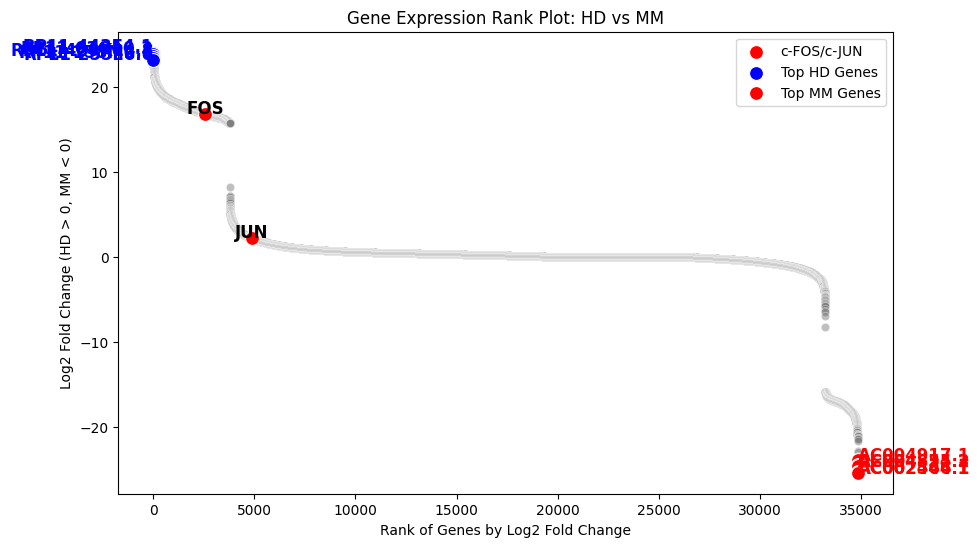

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flip log2 fold change so that HD is positive and MM is negative
de_results['logFC_flipped'] = -de_results['logFC']

# Sort genes by new logFC and reset index to get ranks
de_results_sorted = de_results.sort_values(by='logFC_flipped', ascending=False).reset_index(drop=True)
de_results_sorted['rank'] = de_results_sorted.index + 1  # Rank starts from 1

# Define genes to highlight
highlight_genes = ['JUN', 'FOS', 'c-JUN', 'c-FOS']  # Ensure gene names match your dataset
highlight_data = de_results_sorted[de_results_sorted['gene'].isin(highlight_genes)]

# Select top 5 upregulated genes for HD (highest positive logFC)
top_HD_genes = de_results_sorted.head(5)

# Select top 5 upregulated genes for MM (highest negative logFC, lowest flipped logFC)
top_MM_genes = de_results_sorted.tail(5)

# Create plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=de_results_sorted, x='rank', y='logFC_flipped', color='gray', alpha=0.5)

# Highlight c-FOS and c-JUN in red
sns.scatterplot(data=highlight_data, x='rank', y='logFC_flipped', color='red', s=100, label='c-FOS/c-JUN')

# Highlight top HD genes in blue
sns.scatterplot(data=top_HD_genes, x='rank', y='logFC_flipped', color='blue', s=100, label='Top HD Genes')

# Highlight top MM genes in red
sns.scatterplot(data=top_MM_genes, x='rank', y='logFC_flipped', color='red', s=100, label='Top MM Genes')

# Add gene labels for c-FOS and c-JUN
for i, row in highlight_data.iterrows():
    plt.text(row['rank'], row['logFC_flipped'] + 0.1, row['gene'], fontsize=12, ha='center', color='black', fontweight='bold')

# Add labels for top 5 HD genes in blue
for i, row in top_HD_genes.iterrows():
    plt.text(row['rank'], row['logFC_flipped'] + 0.1, row['gene'], fontsize=12, ha='right', color='blue', fontweight='bold')

# Add labels for top 5 MM genes in red
for i, row in top_MM_genes.iterrows():
    plt.text(row['rank'], row['logFC_flipped'] - 0.1, row['gene'], fontsize=12, ha='left', color='red', fontweight='bold')

# Labels and title
plt.xlabel("Rank of Genes by Log2 Fold Change")
plt.ylabel("Log2 Fold Change (HD > 0, MM < 0)")
plt.title("Gene Expression Rank Plot: HD vs MM")

plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


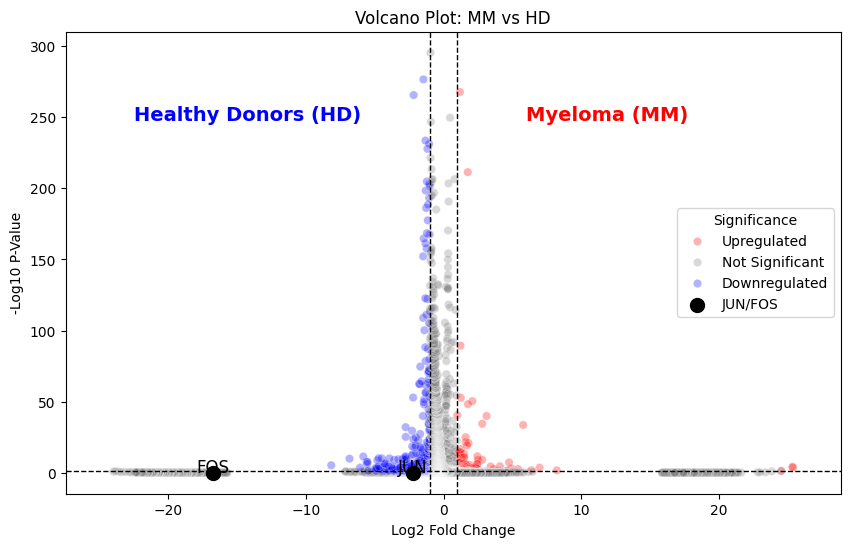

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Downregulated'

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all genes
sns.scatterplot(data=de_results, x='logFC', y=-np.log10(de_results['pval']), hue='significance',
                palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.3)

# Highlight specific genes (e.g., JUN and FOS)
highlight_genes = ['JUN', 'FOS']
highlight_data = de_results[de_results['gene'].isin(highlight_genes)]

# Plot these genes in black with larger markers
plt.scatter(highlight_data['logFC'], -np.log10(highlight_data['pval']), color='black', s=100, label='JUN/FOS')

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD")

# Add gene labels for JUN and FOS
for i, row in highlight_data.iterrows():
    plt.text(row['logFC'], -np.log10(row['pval']) + 0.5, row['gene'], fontsize=12, ha='center', color='black')

# Get min and max values for proper annotation placement
x_min, x_max = plt.xlim()
y_max = plt.ylim()[1]

# Add text annotations for MM and HD with arrow markers
plt.annotate("Healthy Donors (HD)", xy=(-logfc_threshold - 5, y_max * 0.8),
             fontsize=14, color='blue', fontweight='bold', ha='right')

plt.annotate("Myeloma (MM)", xy=(logfc_threshold + 5, y_max * 0.8),
             fontsize=14, color='red', fontweight='bold', ha='left')

# Adjust x-axis limits to ensure labels are visible
plt.xlim(x_min - 1, x_max + 1)

plt.legend(title="Significance")
plt.show()


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


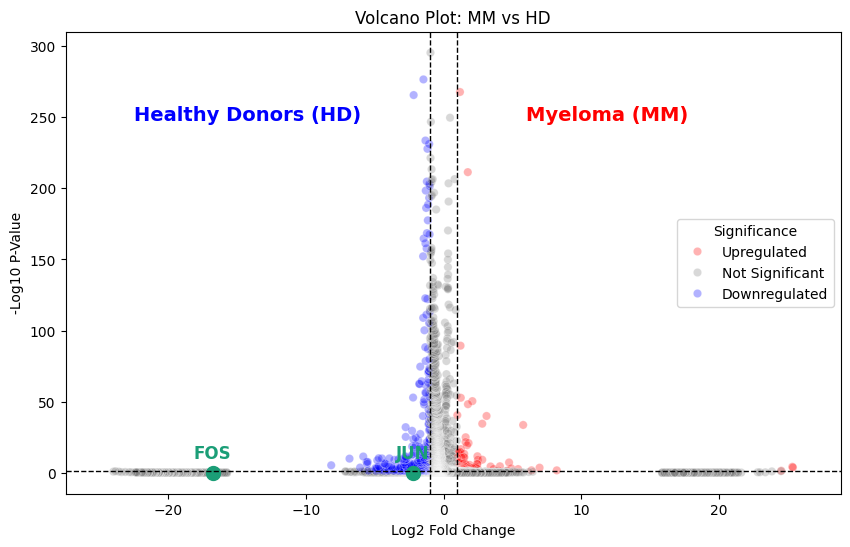

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Downregulated'

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all genes
sns.scatterplot(data=de_results, x='logFC', y=-np.log10(de_results['pval']), hue='significance',
                palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.3)

# Highlight specific genes (e.g., JUN and FOS) in a friendly color (dark green)
highlight_genes = ['JUN', 'FOS']
highlight_data = de_results[de_results['gene'].isin(highlight_genes)]

# Plot these genes in a more friendly color and remove them from the legend
plt.scatter(highlight_data['logFC'], -np.log10(highlight_data['pval']),
            color='#1B9E77', s=100, label="_nolegend_")  # Dark Green

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD")

# Add gene labels for JUN and FOS in the same dark green
for i, row in highlight_data.iterrows():
    plt.text(row['logFC'], -np.log10(row['pval']) + 10, row['gene'],
             fontsize=12, ha='center', color='#1B9E77', fontweight='bold')

# Get min and max values for proper annotation placement
x_min, x_max = plt.xlim()
y_max = plt.ylim()[1]

# Add text annotations for MM and HD with arrow markers
plt.annotate("Healthy Donors (HD)", xy=(-logfc_threshold - 5, y_max * 0.8),
             fontsize=14, color='blue', fontweight='bold', ha='right')

plt.annotate("Myeloma (MM)", xy=(logfc_threshold + 5, y_max * 0.8),
             fontsize=14, color='red', fontweight='bold', ha='left')

# Adjust x-axis limits to ensure labels are visible
plt.xlim(x_min - 1, x_max + 1)

plt.legend(title="Significance")
plt.show()


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


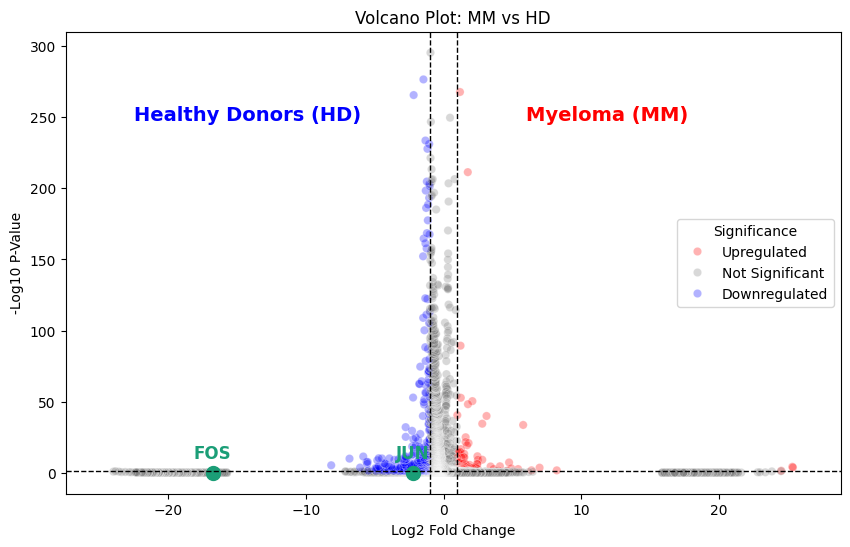

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Downregulated'

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all genes
sns.scatterplot(data=de_results, x='logFC', y=-np.log10(de_results['pval']), hue='significance',
                palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.3)

# Highlight specific genes (e.g., JUN and FOS) in teal for better visibility
highlight_genes = ['JUN', 'FOS']
highlight_data = de_results[de_results['gene'].isin(highlight_genes)]

# Plot these genes in teal and remove them from the legend
plt.scatter(highlight_data['logFC'], -np.log10(highlight_data['pval']),
            color='#1B9E77', s=100, label="_nolegend_")  # Bright Teal

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD")

# Add gene labels for JUN and FOS in teal
for i, row in highlight_data.iterrows():
    plt.text(row['logFC'], -np.log10(row['pval']) + 10, row['gene'],
             fontsize=12, ha='center', color='#1B9E77', fontweight='bold')

# Get min and max values for proper annotation placement
x_min, x_max = plt.xlim()
y_max = plt.ylim()[1]

# Add text annotations for MM and HD with arrow markers
plt.annotate("Healthy Donors (HD)", xy=(-logfc_threshold - 5, y_max * 0.8),
             fontsize=14, color='blue', fontweight='bold', ha='right')

plt.annotate("Myeloma (MM)", xy=(logfc_threshold + 5, y_max * 0.8),
             fontsize=14, color='red', fontweight='bold', ha='left')

# Adjust x-axis limits to ensure labels are visible
plt.xlim(x_min - 1, x_max + 1)

plt.legend(title="Significance")
plt.show()


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


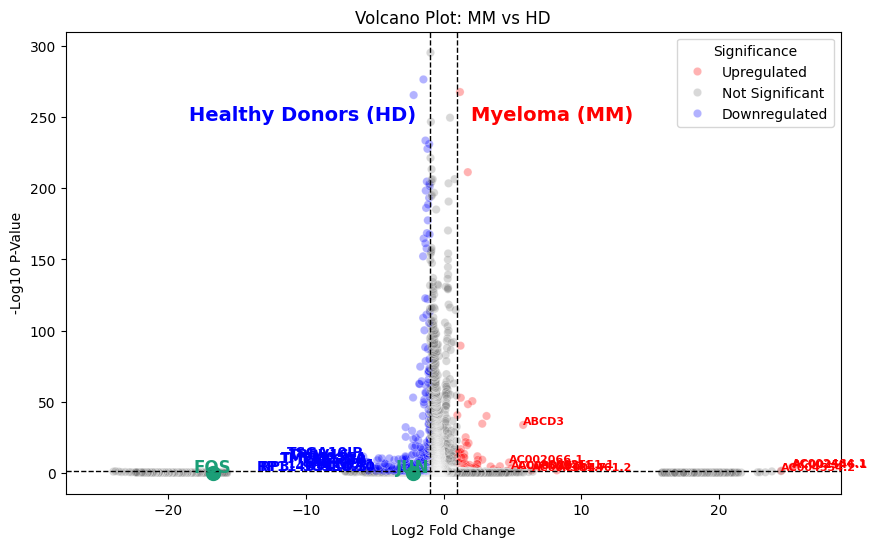

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define significance thresholds
logfc_threshold = 1  # Adjust based on biological relevance
pval_threshold = 0.05

# Color significant genes
de_results['significance'] = 'Not Significant'
de_results.loc[(de_results['logFC'] > logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Upregulated'
de_results.loc[(de_results['logFC'] < -logfc_threshold) & (de_results['pval'] < pval_threshold), 'significance'] = 'Downregulated'

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all genes
sns.scatterplot(data=de_results, x='logFC', y=-np.log10(de_results['pval']), hue='significance',
                palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.3)

# Highlight specific genes (e.g., JUN and FOS) in teal
highlight_genes = ['JUN', 'FOS']
highlight_data = de_results[de_results['gene'].isin(highlight_genes)]
plt.scatter(highlight_data['logFC'], -np.log10(highlight_data['pval']),
            color='#1B9E77', s=100, label="_nolegend_")  # Teal

# Label JUN and FOS
for i, row in highlight_data.iterrows():
    plt.text(row['logFC'], -np.log10(row['pval']) + 0.1, row['gene'],
             fontsize=12, ha='center', color='#1B9E77', fontweight='bold')

# Identify **top 10** upregulated genes in HD (negative logFC, blue) and MM (positive logFC, red)
top_HD_genes = de_results[(de_results['logFC'] < -logfc_threshold) & (de_results['pval'] < pval_threshold)].nsmallest(10, 'logFC')
top_MM_genes = de_results[(de_results['logFC'] > logfc_threshold) & (de_results['pval'] < pval_threshold)].nlargest(10, 'logFC')

# Label top HD genes in blue (Healthy Donors)
for i, row in top_HD_genes.iterrows():
    plt.text(row['logFC'], -np.log10(row['pval']) + 0.1, row['gene'],
             fontsize=10, ha='right', color='blue', fontweight='bold')

# Label top MM genes in red (Myeloma Patients)
for i, row in top_MM_genes.iterrows():
    plt.text(row['logFC'], -np.log10(row['pval']) + 0.2, row['gene'],
             fontsize=8, ha='left', color='red', fontweight='bold')

# Add threshold lines
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-Value")
plt.title("Volcano Plot: MM vs HD")

# Get min and max values for proper annotation placement
x_min, x_max = plt.xlim()
y_max = plt.ylim()[1]

# Add text annotations for MM and HD with arrow markers
plt.annotate("Healthy Donors (HD)", xy=(-logfc_threshold - 1, y_max * 0.8),
             fontsize=14, color='blue', fontweight='bold', ha='right')

plt.annotate("Myeloma (MM)", xy=(logfc_threshold + 1, y_max * 0.8),
             fontsize=14, color='red', fontweight='bold', ha='left')

# Adjust x-axis limits to ensure labels are visible
plt.xlim(x_min - 1, x_max + 1)

plt.legend(title="Significance")
plt.show()


In [ ]:
order = ['HD','MGUS','SMM','MM']
counts = (df.groupby('sample_category')['sample_id']
            .nunique()
            .reindex(order, fill_value=0))
print(counts)
print('Total samples:', counts.sum())


sample_category
HD      91
MGUS    21
SMM     41
MM      61
Name: sample_id, dtype: int64
Total samples: 214
